# Load Data

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [2]:
x = mnist['data']
y = mnist.target

In [3]:
len(x)

70000

# Train Model
skipping cleaning and understanding data since we know what MNIST data looks like. 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 10000)

In [5]:
%timeit
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, verbose=1, n_estimators=100, n_jobs=-1)

forest_clf.fit(X_train, y_train)

 #time how long it takes to train data

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.7s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

# Evaluate Random Forest Model

In [6]:
from sklearn.metrics import accuracy_score

y_pred_forest = forest_clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred_forest)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9706

####  Very good score, Random Forest seems to work really well with the data set.

# Now Compare this to PCA

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) #variance we would like to maintain

In [8]:
X_reduced = pca.fit_transform(X_train[:2000]) #memory problems so unable to process the entire data set :(

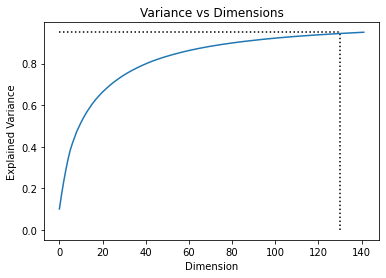

In [9]:
import matplotlib.pyplot as plt
cumsum = np.cumsum(pca.explained_variance_ratio_) 

plt.plot([130, 130], [0, 0.95], "k:")
plt.plot([0, 130], [0.95, 0.95], "k:")
plt.title('Variance vs Dimensions')
plt.ylabel('Explained Variance')
plt.xlabel('Dimension')
plt.plot(cumsum)

In [10]:
%timeit
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, verbose=1, n_estimators=100, n_jobs=-1)
y_train_reduced = y_train[:2000]
forest_clf.fit(X_reduced, y_train_reduced)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [11]:
%timeit
X_test_reduced = pca.transform(X_test)
y_pred_forest_reduced = forest_clf.predict(X_test_reduced)

accuracy_score(y_test, y_pred_forest_reduced)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.875

# performance has reduced and the overall time have increased (because of PCA NOT random forest as the training time would have reduced due to the reduced dimensionality). 

# Reduce Dimensionality using t-SNE with MNIST data
using a reduce data set because my laptop is unable to process dimensionality reduction for 70000 instances. 

In [12]:
np.random.seed(42)

m = 10000

idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

(-98.25756759643555, 84.90846176147461, -91.74277687072754, 88.49925422668457)

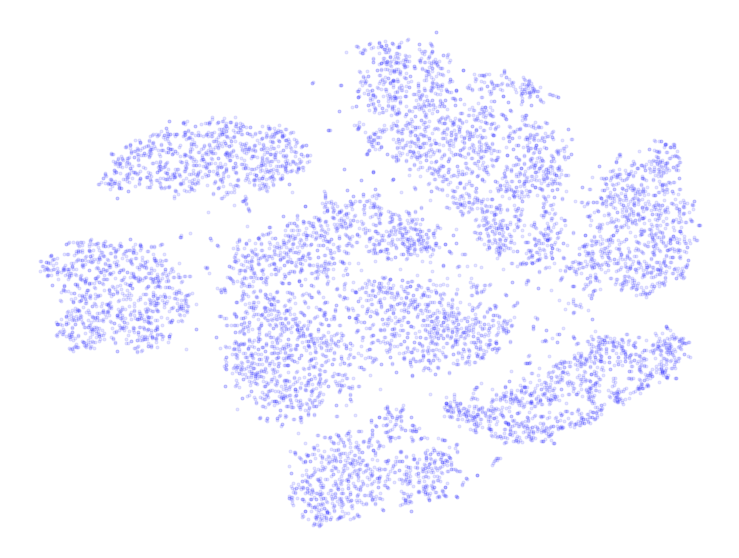

In [14]:
plt.figure(figsize= (13,10))
plt.plot(X_reduced[:, 0], X_reduced[:,1], 'b.', alpha=0.1)
plt.axis('off')


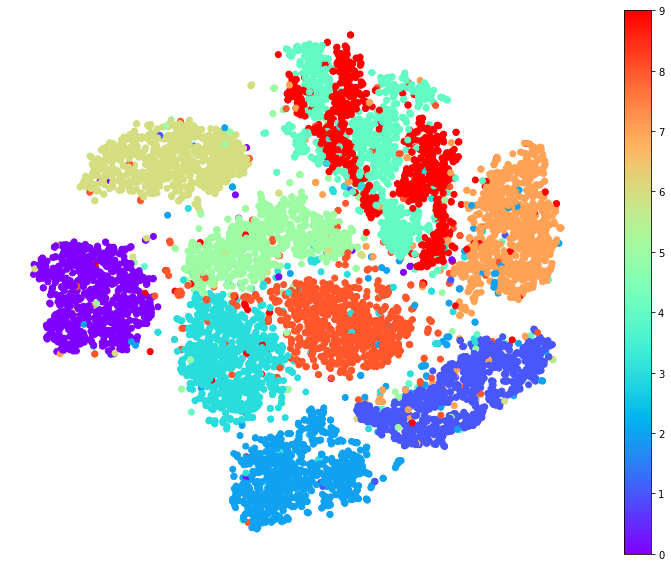

In [15]:
#Let add some colour
plt.figure(figsize= (13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:,1], c= y[:m], cmap='rainbow')
plt.axis('off')
plt.colorbar()
plt.show()


#### I spent a good 10 mins looking at this. you can clearly see which colours are easily identified. 0 and 6 for example have very clear clusters. Whereas, 4 and 9 are very close to each other, which is what you'd expect because some of the handwritting in the MNIST data is barely legible. 
### TNIS worked really well, how about PCA and some others?
Note, I wish I could show more but due to the limited computational memory I have, I am limited in how large the number of training data I can use. 
But here goes nonetheless. 

# Multidimensional Scaling (MDS)
MDS does not provide as much of a visualization in comparison to T-SNE

In [16]:

from sklearn.manifold import MDS

mds = MDS(n_components= 2 , random_state=42, verbose=1)

X_reduced_mds = mds.fit_transform(X[:1000])

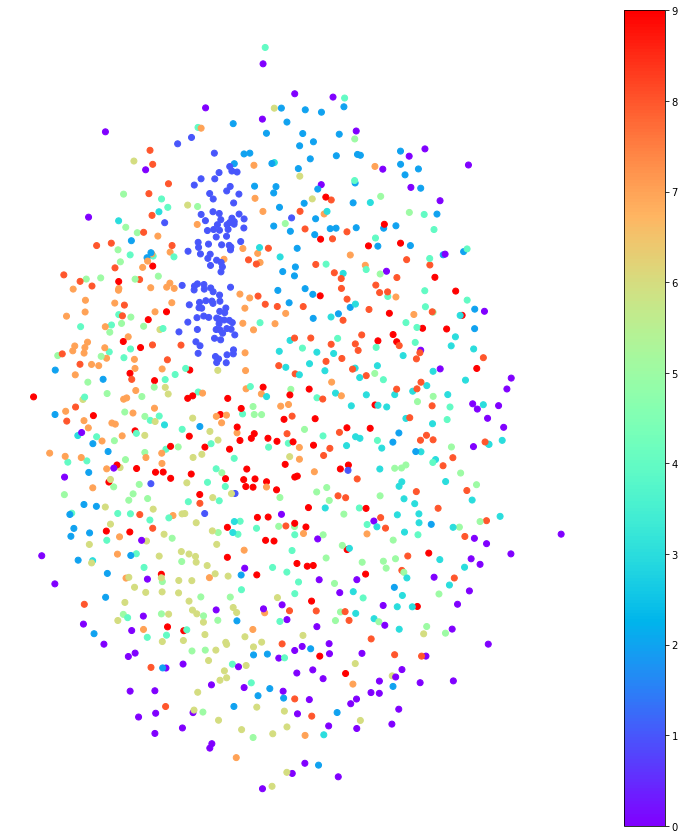

In [17]:
y_reduced_mds = y[:1000]

plt.figure(figsize=(13,15))
plt.scatter(X_reduced_mds[:,0], X_reduced_mds[:, 1], c= y_reduced_mds, cmap='rainbow')
plt.axis('off')
plt.colorbar()
plt.show()

# Linear Discriminant Analysis (LDA)
Not as great, you can see that if the number of instances increased, there would be clashes. 

In [18]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%timeit 
X_reduced_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(X[:1000], y[:1000])

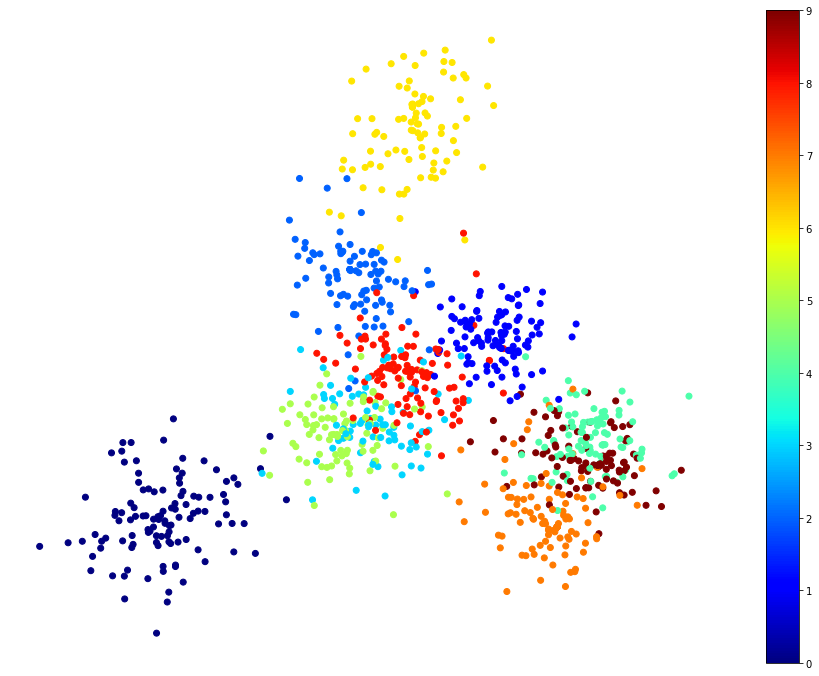

In [19]:
plt.figure(figsize=(16,12))
plt.axis('off')
plt.scatter(X_reduced_lda[:,0], X_reduced_lda[:,1], c=y[:1000], cmap='jet')
plt.colorbar()
plt.show()

# It's clear the T-SNE won, but it does take a long time. Maybe, let's try use PCA and T-SNE together to speed it up. 

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_tsne = Pipeline([
    ('pca', PCA(random_state= 42, n_components= 0.95)),
    ('tsne', TSNE(random_state=42, n_components= 2))
])

%timeit

X_reduced_pca_tsne = pca_tsne.fit_transform(X[:1000])


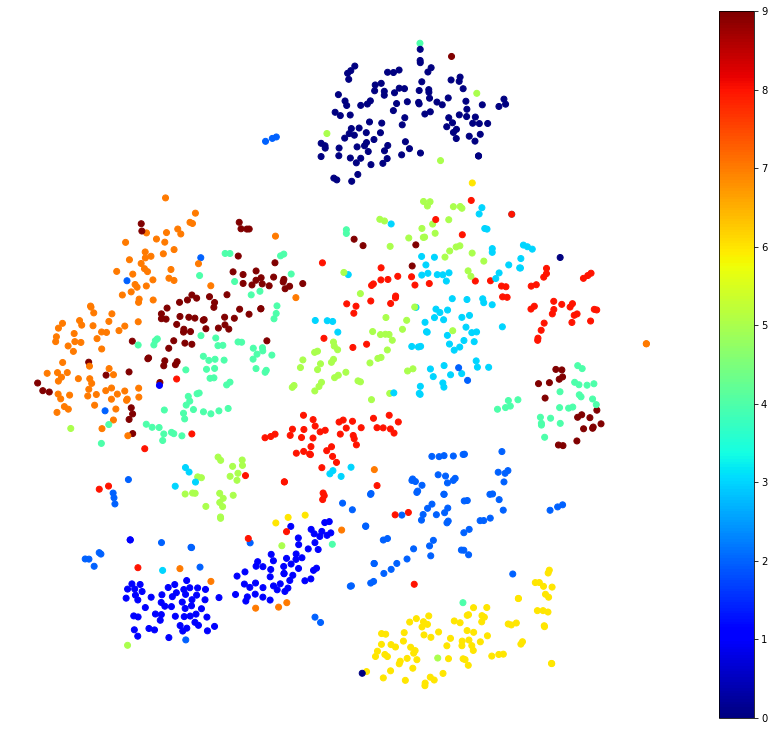

In [21]:
plt.figure(figsize= (15, 13))
plt.axis('off')
plt.scatter(X_reduced_pca_tsne[:, 0], X_reduced_pca_tsne[:,1], c=y[:1000], cmap='jet')
plt.colorbar()
plt.show()